<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/LC_FFT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP trained on Lightcruves

---



### Install the lightkurve libary and import the necessary packages

In [14]:
!pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import scipy
from scipy.fft import fft, fftfreq
from scipy import signal
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from scipy.fft import fft, ifft
from sklearn import neural_network

### Read the KOI.csv file into a data frame and select only the CONFIRMED candidates

In [120]:
#KOI_first_100 = pd.read_csv('KIC_first_100.csv')
KOI = pd.read_csv('KOI.csv')
KOI.drop(KOI.columns[0], axis=1, inplace=True)
KOI = KOI.drop(KOI[KOI['koi_disposition']!='CONFIRMED'].index)
KOI = KOI[KOI['koi_prad'].notna()]
KOI.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.43,0.94,-0.00020,-0.00055,-0.01,0.20,0.20,0.08,0.31,0.32
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,-0.63,1.23,0.00066,-0.00105,0.39,0.00,0.39,0.49,0.12,0.50
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.01,0.23,0.00008,-0.00007,0.03,-0.09,0.10,0.07,0.02,0.07
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.12,0.14,0.00004,NaN,0.04,-0.07,0.08,-0.02,-0.08,0.08
6,10872983,K00756.02,Kepler-228 c,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.14,-0.32,-0.00016,NaN,0.25,0.09,0.26,0.18,0.06,0.19


A sample light curve would look like this

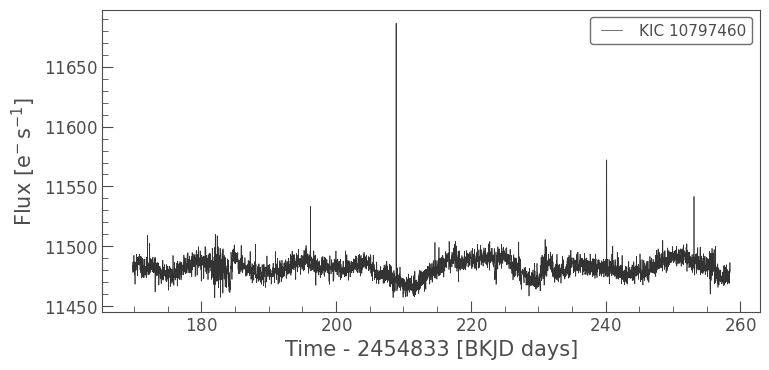

In [121]:
search_result_q2 = lk.search_lightcurve('KIC ' + str(KOI['kepid'][0]), author='Kepler', quarter=2)
lc = search_result_q2.download()
lc = lc.fill_gaps()
lc.plot()

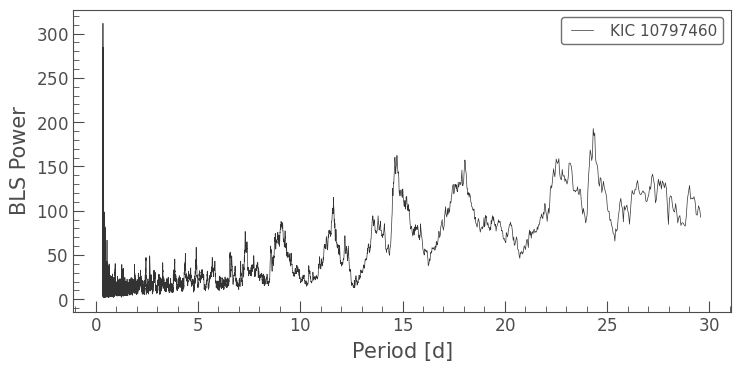

In [122]:
f = lc['flux'].value
t = lc['time'].value
periodogram = lc.to_periodogram(method='bls')
periodogram.plot()

For each light curve its Fourier Transform is computed. As stellar activity is the dominant part of the light curve initial frequencies in the Fourier transform can be set to zero. Then we compute the inverse fourier transform to get the filtered light curve

Text(0, 0.5, 'Flux')

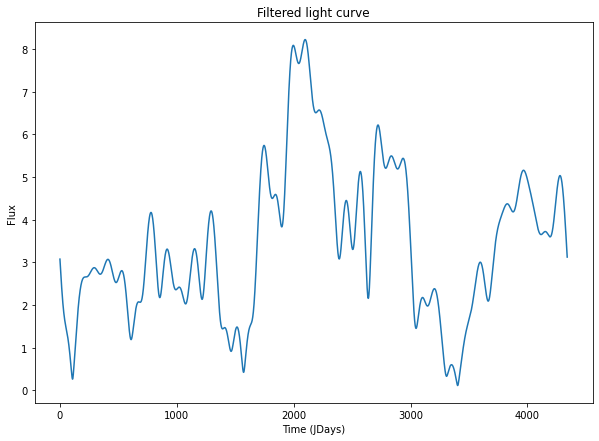

In [123]:
s = fft(f)
s[:4300] = 0
f_cleared = np.abs(ifft(s))
plt.plot(f_cleared)
plt.title('Filtered light curve')
plt.xlabel('Time (JDays)')
plt.ylabel('Flux')

## Downloading and filtering lightcurves

Performing the above steps for all the light curves and storing them in the flux array

In [144]:
outlier_size = 41820
outlier_size_threshold = 4075
flux = np.empty([4075,])
time = np.empty([4075,])
download_failed_index = []
radius = []
for index, rad in zip(KOI.T, KOI['koi_prad']):
  try:
    search_result_q2 = lk.search_lightcurve('KIC ' + str(KOI.iloc[index]['kepid']), author='Kepler', quarter=2)
    lc = search_result_q2.download()
    lc = lc.fill_gaps(method='gaussian_noise')
    flux_small = lc['flux'].value
    time_small = lc['time'].value
    y = np.abs(fft(flux_small))
    y[:400] = 0
    f_cleared = np.abs(ifft(y))
    #periodogram = lc.to_periodogram(method='bls')
    #power = periodogram.power.to_value()
    #period = periodogram.period.to_value()
    if f_cleared.size > outlier_size_threshold:
      f_cleared = f_cleared[:outlier_size_threshold]
      time_small = time_small[:outlier_size_threshold]

    flux = np.vstack((flux, f_cleared))
    time = np.vstack((time, time_small))
    radius.append(rad)
  except:
    download_failed_index.append(index)
flux = flux[1:]
time = time[1:]

/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:402: LightkurveWarning: Cannot download fro

## Preprocessing data for the model

In [168]:
X, y = flux, np.array(radius)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Scaling the flux data

In [169]:
for i in range(len(X_train)):
  X_mean = np.mean(X_train[i])
  X_std = np.std(X_train[i])
  X_train_man_std = (X_train[i] - X_mean) / X_std
  X_train[i] = X_train_man_std

for i in range(len(X_test)):
  X_mean = np.mean(X_test[i])
  X_std = np.std(X_test[i])
  X_test_man_std = (X_test[i] - X_mean) / X_std
  X_test[i] = X_test_man_std

### Normalizing the flux data

In [170]:
for i in range(len(X_train)):
  X_max = np.max(X_train[i])
  X_min = np.min(X_train[i])
  X_train_man_norm = (X_train[i] - X_min) / (X_max - X_min)
  X_train[i] = X_train_man_norm

for i in range(len(X_test)):
  X_max = np.max(X_test[i])
  X_min = np.min(X_test[i])
  X_test_man_norm = (X_test[i] - X_min) / (X_max - X_min)
  X_test[i] = X_test_man_norm

### Validation split

In [171]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Building and training the MLP

In [172]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes=(100, 20), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001,
                 power_t=0.5, max_iter=1000,tol=1e-4)

mlp.fit(X_train, y_train)
r = mlp.score(X_train, y_train)
y_predict = mlp.predict(X_test)  

Function to plot predictions

In [173]:
def test_validate1(x_test, y_test, y_predict, regressor, set_name):
    x = range(len(y_test))
    per_error = [abs(i-j)/i*100 if i != 0 else None for i,j in zip(y_test,y_predict)]
    plt.plot(x, per_error, "bo", markersize=6, zorder=2, label=u"=%.3f" % abs(regressor.score(x_test, y_test)))
    plt.axhline(y=0, color='red', linestyle='--', linewidth=3, label="0% error")
    plt.legend(loc="upper left", prop={'size': 14})
    plt.xlabel("Exoplanet Sample Index", fontsize = 14)
    plt.ylabel("Exoplanet Radius Percent Error (%)", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, len(per_error), -10, 100])
    plt.title("Accuracy of MLPRegressor Exoplanet Radii Predictions (" + set_name + ')', fontsize = 14)
    plt.show()

def test_validate2(x_test, y_test, y_predict, regressor, set_name):
    x = range(len(y_test))
    plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, y_predict, "bo", markersize=8, zorder=2, label=u"predicted, =%.3f" % abs(regressor.score(x_test, y_test)))
    plt.legend(loc="lower left", prop={'size': 14})
    plt.xlabel("Exoplanet Sample Index", fontsize = 14)
    plt.ylabel("Exoplanet Radius R$_{Earth}$", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, len(y_test), -3,20])
    plt.title("Accuracy of MLPRegressor Exoplanet Radii Predictions (" + set_name + ')',fontsize = 14)
    plt.show()

## Loss vs Epoch

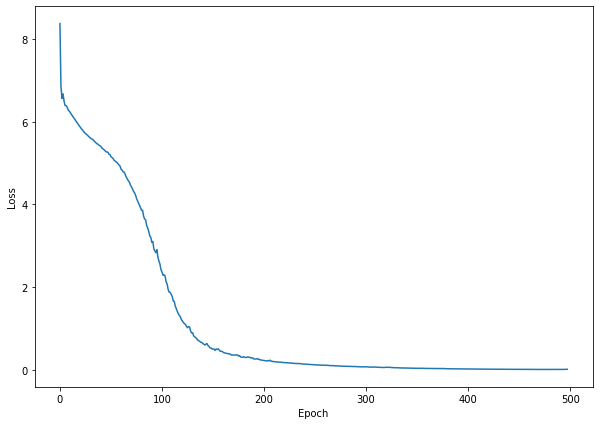

In [174]:
pd.DataFrame(mlp.loss_curve_).plot(xlabel="Epoch", ylabel="Loss", legend=False)

## Accuracy of MLP

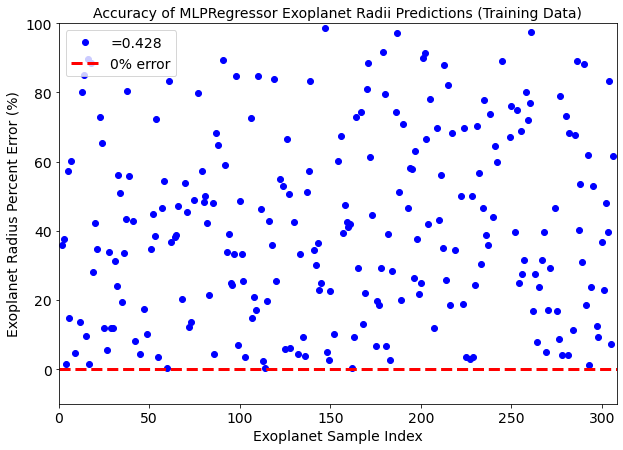

In [175]:
test_validate1(X_test, y_test, y_predict, mlp, 'Training Data')

## Performance on Testing data

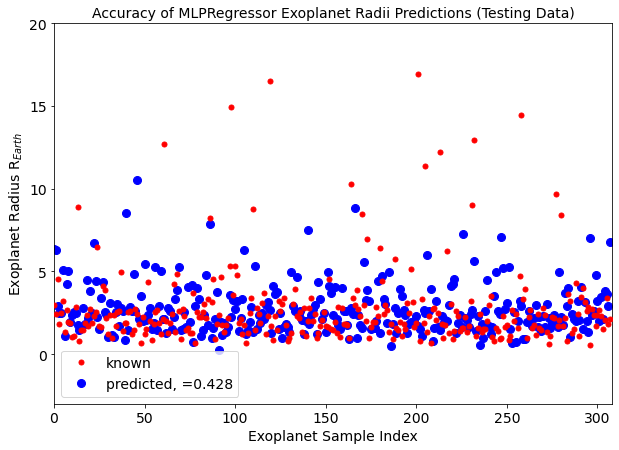

In [176]:
test_validate2(X_test, y_test, y_predict, mlp, 'Testing Data')

## Performance on validation data

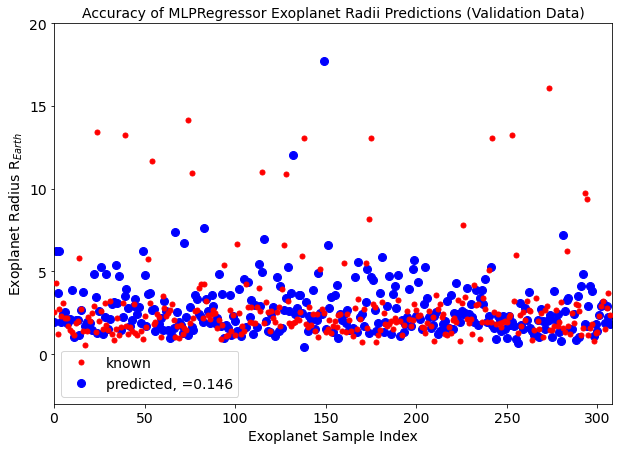

In [178]:

y_val_pred = mlp.predict(X_val)
test_validate2(X_val, y_val, y_val_pred, mlp, 'Validation Data')